### Proxy (To connect OpenAI in China)


In [1]:
import socket
import socks
socks.set_default_proxy(socks.SOCKS5, "127.0.0.1", 7890)
socks.set_default_proxy(socks.HTTP, "127.0.0.1", 7890)
socket.socket = socks.socksocket

### Configs

In [2]:
env_args = {
    "stock_name" : "AAPL",       
    "start_date":"2014-01-01",
    "end_date":"2015-12-30",
    "init_cash": 100,
    "init_hold": 0,
    "trade_volumn": 100,
}

In [3]:
from openai_token.token_ import OPEN_AI_TOKEN      # You may just paste you own openai token
agent_args = {
    "model_name": "text-davinci-003", # "text-curie-001","text-davinci-003"
    "source": "local",                # "local","openai"
    "api_key": OPEN_AI_TOKEN,         # not necessary when the "source" is "local"
    "buy_threshold": 0.3,             # the max positive sentiment is 1, so this should range from 0 to 1 
    "sell_threshold": -0.3            # the min negative sentiment is -1, so this should range from -1 to 0
}

### Env

In [4]:
import gym
import json
import pandas as pd
from easydict import EasyDict as edict
from tqdm.notebook import tqdm


class Tweets_trading_env(gym.Env):
    def __init__(self,args):
        args = edict(args)
        self.stock_name = args.stock_name
        self.start_date = args.start_date
        self.end_date = args.end_date
        self.init_cash = args.init_cash if "init_cash" in args.keys() else 100
        self.init_hold = args.init_hold if "init_hold" in args.keys() else 0
        self.cal_on = args.cal_on if "cal_on" in args.keys() else "Close"
        self.trade_volumn = args.trade_volumn if "trade_volumn" in args.keys() else 100
        
        self.read_file(args.stock_name)

    def read_file(self,stock_name):
        # sentences
        sentence_path = f"../../stocknet-dataset/tweet/preprocessed/{stock_name}/"
        self.tweets_df = pd.DataFrame()
        print("missing (empty means not missing):", end = " ")
        for date in pd.date_range(self.start_date,self.end_date):
            date = date.date().strftime("%Y-%m-%d")
            file_path = f"{sentence_path}/{date}"
            try:
                with open(file_path, "r") as f:
                    sentences = f.readlines()
                sentences_dict = [json.loads(i) for i in sentences]
                sentences = [" ".join(i["text"]) for i in sentences_dict]
                date = [date for i in sentences_dict]
                time_ = [pd.to_datetime(i["created_at"]).time() for i in sentences_dict]
                user_id_str = [i["user_id_str"] for i in sentences_dict]
                temp_df = pd.DataFrame([sentences,date,time_,user_id_str]).T
                # print(temp_df)
                self.tweets_df = pd.concat([self.tweets_df,temp_df])
            except:
                print(date,end = " ")
        self.tweets_df.columns = ["text","date","time","user_id"]
        self.tweets_df = self.tweets_df.reset_index(drop= True)
        self.date_list = self.tweets_df.sort_values("date")["date"].unique().tolist()

        # Prices
        price_path = f"../../stocknet-dataset/price/raw/{stock_name}.csv"
        self.price_df = pd.read_csv(price_path)
        self.price_df = self.price_df[self.price_df.Date.isin(self.date_list)]
        self.price_df[self.cal_on] /= self.price_df.iloc[0][self.cal_on]
        self.date_list = self.price_df.sort_values("Date")["Date"].unique().tolist()

    def reset(self):
        self.day_index = 0
        self.today = self.date_list[self.day_index]
        self.today_sentences = self.tweets_df[self.tweets_df.date == self.today]
        self.today_price = self.price_df[self.price_df["Date"] == self.today]
        self.today_cash = self.init_cash
        self.today_hold = self.init_hold
        self.terminal = False
        self.asset_memory = [self.init_hold * self.today_price[self.cal_on].item() + self.today_cash]
        self.hold_memory = [self.init_hold]
        self.cash_memory = [self.init_cash]
        self.reward_momory = [0]
        self.action_memory = [0]

        return self.today_sentences.text.tolist()
    
    def update(self):
        if self.day_index >= len(self.date_list)-1:
            self.terminal = True
        else:
            self.day_index += 1
            self.today = self.date_list[self.day_index]
            self.today_sentences = self.tweets_df[self.tweets_df.date == self.today]
            self.today_price = self.price_df[self.price_df["Date"] == self.today]

    def step(self,action):
        last_price = self.today_price[self.cal_on].item()
        last_hold = self.today_hold
        last_cash = self.today_cash
        last_asset = last_price * last_hold + last_cash
        self.update()
        if self.terminal:
            print("\n\nall_done")
        else:
            next_price = self.today_price[self.cal_on].item()
            if action >0:
                buy_cost = self.trade_volumn * next_price
                today_cash = self.today_cash - buy_cost
                if today_cash >= 0 :
                    self.today_hold += self.trade_volumn 
                    self.today_cash = today_cash
                else:
                    avaliable_volumn = self.today_cash / next_price
                    self.today_hold += avaliable_volumn
                    self.today_cash = 0

            
            elif action <0:
                today_hold = self.today_hold - self.trade_volumn 
                if today_hold >= 0:
                    sell_earn = self.trade_volumn * next_price
                    self.today_cash += sell_earn
                    self.today_hold = today_hold
                else:
                    self.today_cash += next_price * self.today_hold
                    self.today_hold = 0
            
            else:
                pass
                
            next_asset = self.today_hold * next_price +  self.today_cash   
            self.reward = next_asset - last_asset
            self.asset_memory.append(next_asset)
            self.hold_memory.append(self.today_hold)
            self.reward_momory.append(self.reward)
            self.action_memory.append(action)
            self.cash_memory.append(self.today_cash)
        
        return self.today_sentences.text.tolist(), self.reward ,self.terminal ,{}
    

### GPT Agent

In [5]:
import openai
import numpy as np
import pickle
import time

class GPT_agent:
    def __init__(self, args):
        args = edict(args)
        self.model_name = args.model_name
        self.source = args.source
        self.buy_threshold = args.get("buy_threshold", 0.3)
        self.sell_threshold = args.get("sell_threshold", -0.3)

        # Init
        if self.source == "openai":
            openai.api_key = args.api_key
        elif self.source == "local":
            with open(f"./data/{self.model_name}.pkl", "rb") as f:
                self.sentiment_dict = pickle.load(f)

    def __call__(self, obs):
        self.score_list = [self.get_sentiment(o) for o in obs]
        self.score_list_mean = np.mean(self.score_list)
        return 1 if self.score_list_mean > self.buy_threshold else -1 if self.score_list_mean < self.sell_threshold else 0

    def get_sentiment(self, sentence):
        if self.source == "openai":
            time.sleep(1)
            response = openai.Completion.create(
                model=self.model_name,
                prompt=f"Decide whether a sentence's sentiment is positive, neutral, or negative.\n\nSentence: \"{sentence}\"\nSentiment: ",
                temperature=0,
                max_tokens=60,
                top_p=1,
                frequency_penalty=0.5,
                presence_penalty=0
            )
            response = response["choices"][0]["text"]
        elif self.source == "local":
            response = self.sentiment_dict.get(sentence, "")

        if "negative" in response.lower():
            return -1
        elif "positive" in response.lower():
            return 1
        else:
            return 0


### Trade

In [6]:
env = Tweets_trading_env(env_args)
agent = GPT_agent(agent_args)
obs = env.reset()
terminal = False
while not terminal:
    action = agent(obs)
    obs,reward,terminal,info = env.step(action)

missing (empty means not missing): 2014-01-17 2014-01-18 2014-06-17 2014-08-05 2014-08-06 2014-09-24 2014-09-25 2014-09-26 2014-09-27 2014-09-28 2014-11-10 2014-11-11 2014-11-12 2014-11-13 2014-11-15 2014-11-16 2014-11-17 2014-11-18 2014-11-19 2014-11-20 2014-11-21 2014-11-22 2014-11-23 2014-12-20 2015-03-08 2015-06-05 2015-06-23 2015-07-08 2015-08-15 2015-09-17 2015-09-18 2015-11-27 2015-12-16 2015-12-18 

all_done


### Plot

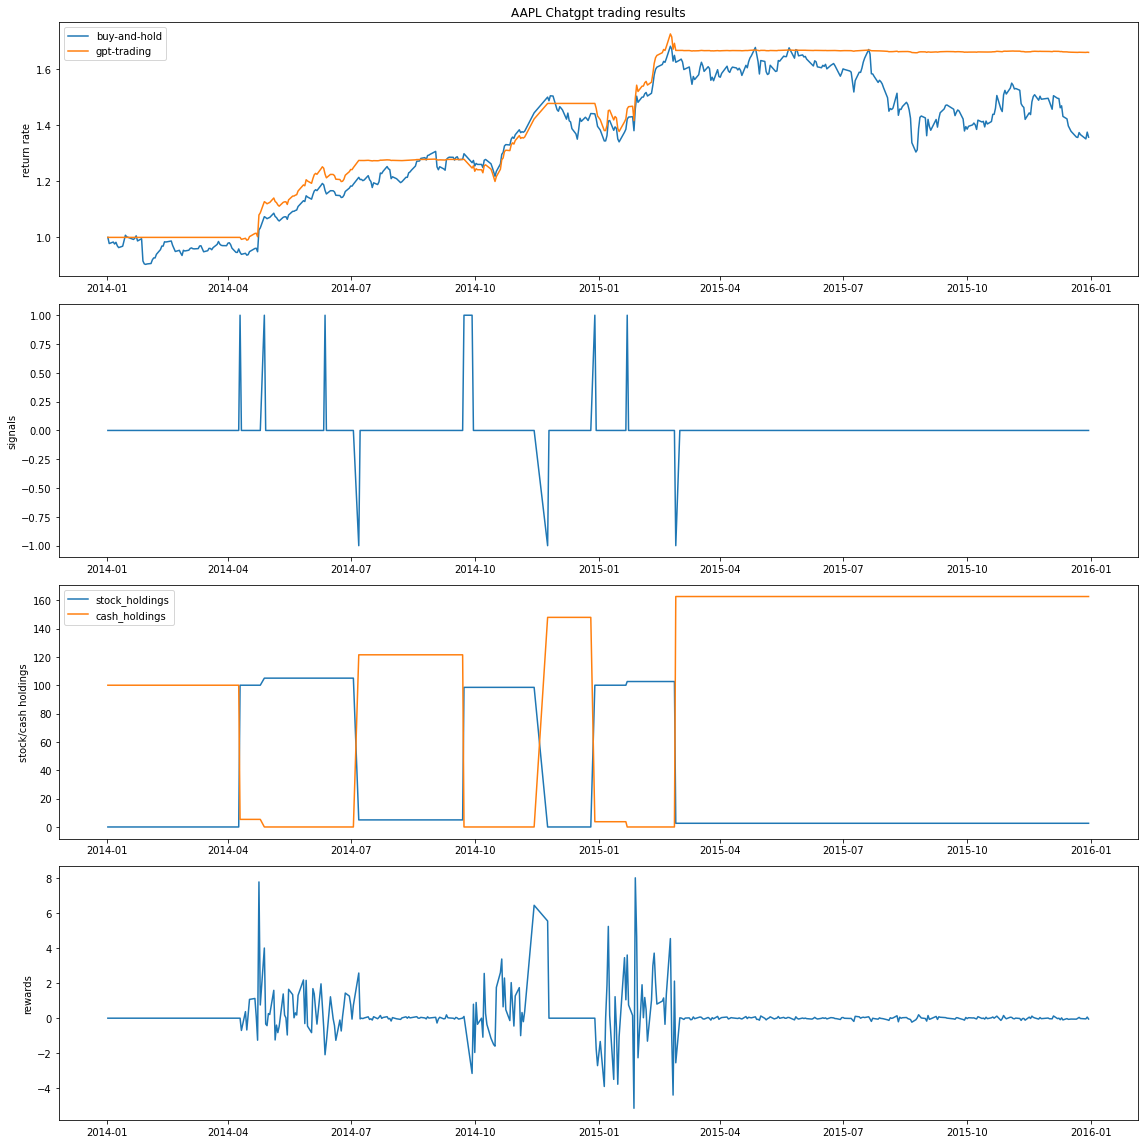

In [7]:
import matplotlib.pyplot as plt
from datetime import datetime
plt.figure(figsize=(16,4*4),facecolor='white')


# assets
plt.subplot(4,1,1)
assets = env.asset_memory
assets = [i/assets[0] for i in assets]
xs = [datetime.strptime(d, '%Y-%m-%d').date() for d in env.date_list]
plt.title("AAPL Chatgpt trading results")
plt.plot(xs,env.price_df.reset_index(drop = True).Close.tolist(),label = "buy-and-hold")
plt.plot(xs,assets,label = "gpt-trading")
plt.ylabel("return rate")
plt.legend()

# singals
plt.subplot(4,1,2)
actions = env.action_memory
plt.plot(xs,actions,label = "signals")
plt.ylabel("signals")

# stock/cash holdings
plt.subplot(4,1,3)
holds = env.hold_memory
cash = env.cash_memory
plt.plot(xs,holds,label = "stock_holdings")
plt.plot(xs,cash,label = "cash_holdings")
plt.ylabel("stock/cash holdings")
plt.legend()

# earnings
plt.subplot(4,1,4)
rewards = env.reward_momory
plt.plot(xs,rewards,label = "rewards")
plt.ylabel("rewards")
plt.savefig("output.png")

plt.tight_layout()
plt.show()

### Backtest

In [8]:
# return rate
(env.asset_memory[-1]-env.asset_memory[0])/env.asset_memory[0]

0.6611161275697802

In [14]:
account_value = env.asset_memory
baseline_value = env.price_df.Close.tolist()
date_list = env.date_list

df_account_value = pd.DataFrame([date_list,account_value],index= ["time","account_value"]).T
df_baseline = pd.DataFrame([date_list,baseline_value],index= ["time","account_value"]).T

df_account_value.head(2)

,time,account_value
0,2014-01-02,100.0
1,2014-01-03,100.0


In [15]:
def get_return(df, value_col_name="account_value"):
    df["daily_return"] = df[value_col_name].pct_change(1)
    df["time"] = pd.to_datetime(df["time"], format="%Y-%m-%d")
    df.set_index("time", inplace=True, drop=True)
    df.index = df.index.tz_localize("UTC")
    return pd.Series(df["daily_return"], index=df.index)

In [16]:
import pyfolio
from pyfolio import timeseries
daily_return = get_return(df_account_value)
daily_return_base = get_return(df_baseline)

perf_func = timeseries.perf_stats
perf_stats_all = perf_func(returns=daily_return, 
                              factor_returns=daily_return_base, 
                                positions=None, transactions=None, turnover_denom="AGB")
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return          0.306025
Cumulative returns     0.661116
Annual volatility      0.134534
Sharpe ratio           2.055749
Calmar ratio           4.514700
Stability              0.868554
Max drawdown          -0.067784
Omega ratio            1.997149
Sortino ratio          4.298199
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.838620
Daily value at risk   -0.015852
Alpha                  0.241364
Beta                   0.313467
dtype: float64

Start date,2014-01-02
End date,2015-12-30
Total months,22
,Backtest
Annual return,30.603%
Cumulative returns,66.112%
Annual volatility,13.453%
Sharpe ratio,2.06
Calmar ratio,4.51
Stability,0.87
Max drawdown,-6.778%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,6.78,2014-12-29,2015-01-16,2015-01-28,23
1,6.25,2014-09-02,2014-10-16,2014-10-22,37
2,4.21,2014-06-10,2014-06-24,2014-07-07,20
3,3.90,2015-02-23,2015-08-24,NaT,NaN
4,2.57,2014-05-05,2014-05-09,2014-05-19,11


Stress Events,mean,min,max
Apr14,0.54%,-1.24%,7.76%
Oct14,0.31%,-1.56%,2.72%
Fall2015,-0.00%,-0.14%,0.12%
New Normal,0.11%,-3.50%,7.76%


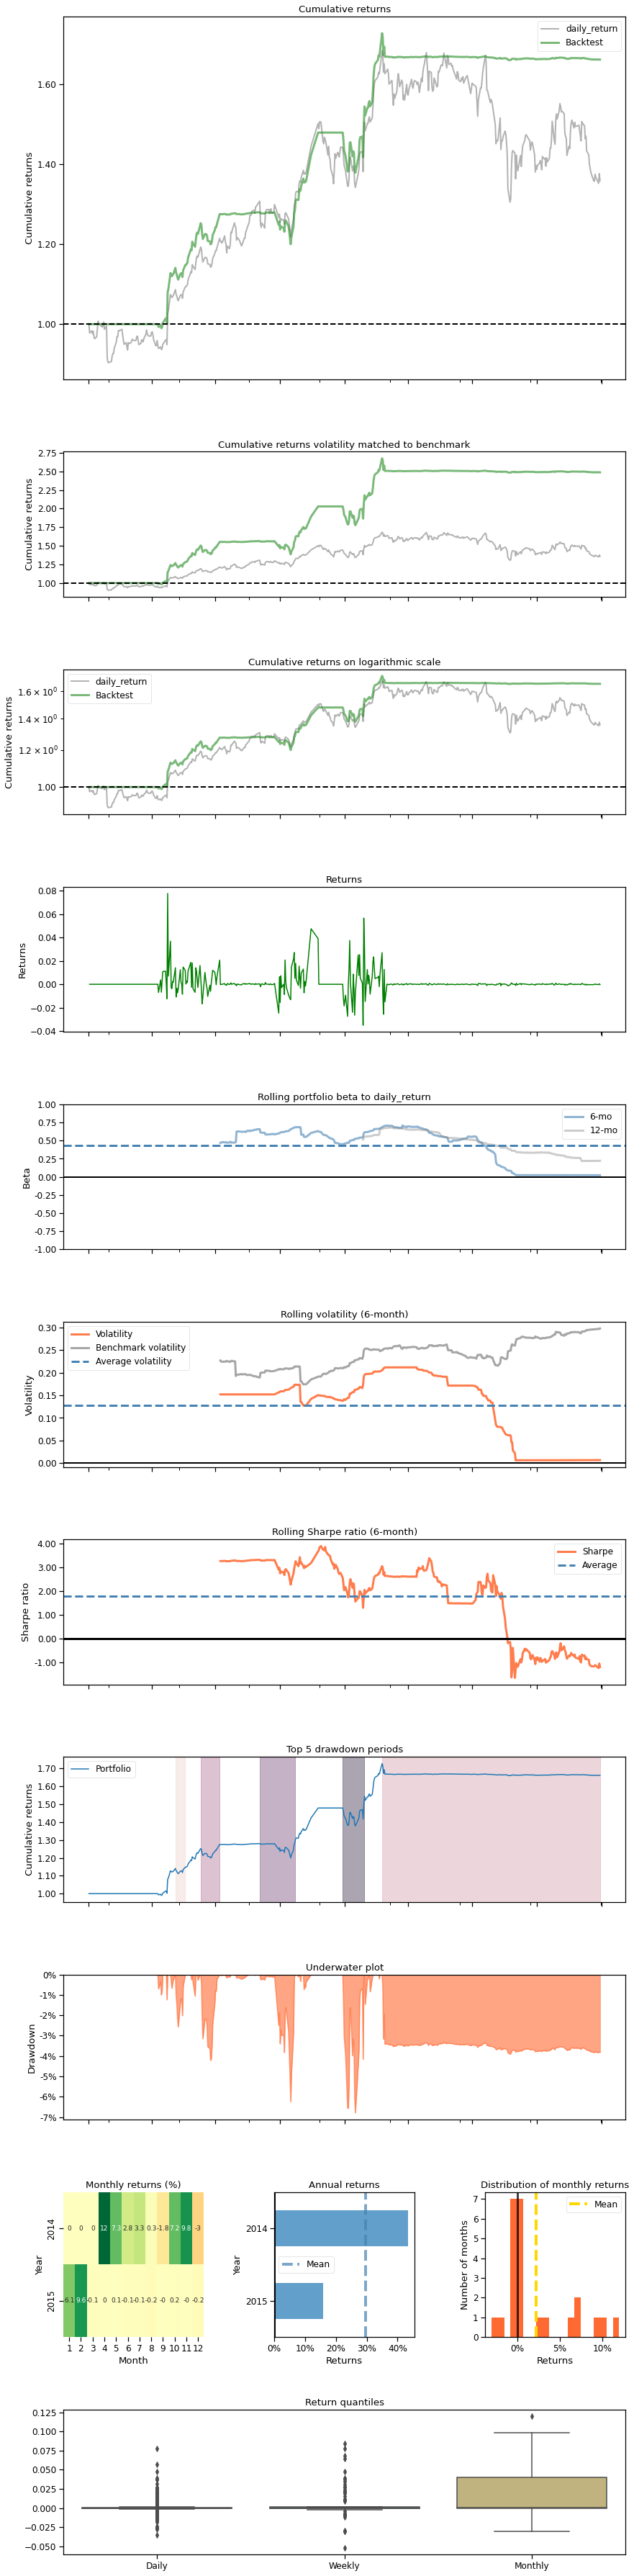

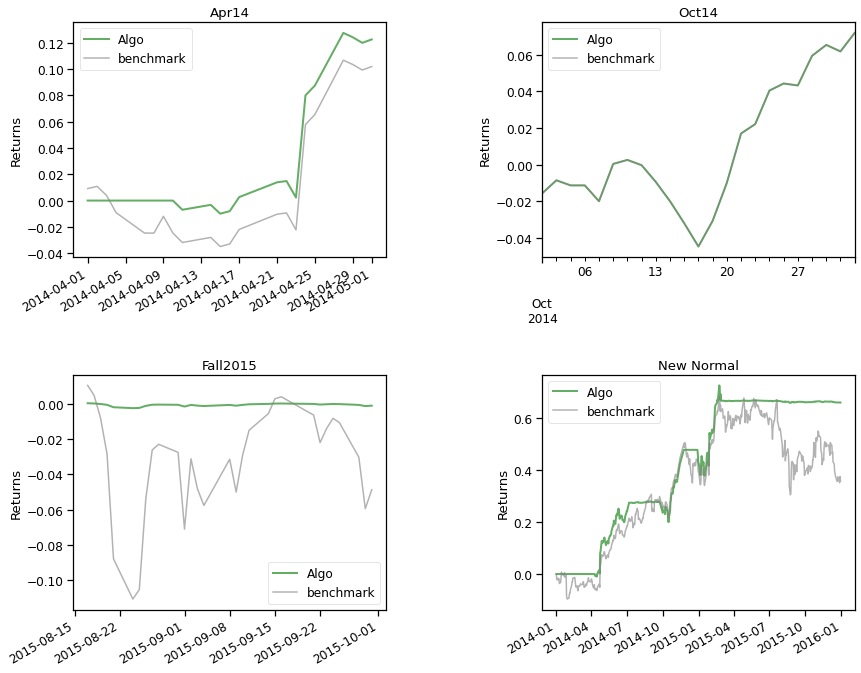

In [12]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = daily_return,
                                       benchmark_rets = daily_return_base, set_context=False)